# Reinforcement Learning Mouse Model of Maze Discovery


### Importing neccesary libraries for data creation and visualization


In [1]:
import csv
import datetime
import json
import os
import random
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

2025-04-21 16:17:31.286628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Code for simulating a rat in a maze with actions, agent and reward


In [2]:
# create the colors
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
mouse_mark = 0.5  # The current rat cell will be painted by gray 0.5

# numerically assign valus to possible actions
# assume rat cannot move diagonal
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict: dict[int, str] = {
    LEFT: "left",
    UP: "up",
    RIGHT: "right",
    DOWN: "down",
}

num_actions: int = len(actions_dict)

# Exploration factor
#  one of every 10 moves the agent takes a completely random action
epsilon: float = 1 / 10


# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# mouse = (row, col) initial mouse position (defaults to (0,0))


class Qmaze(object):
    def __init__(
        self,
        maze: list,
        mouse: list = (0, 0),
        valid_penalty: float = -0.04,
        invalid_penality: float = -0.75,
        visited_penality: float = -0.25,
    ):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self._valid_penality = valid_penalty
        self._invalid_penality = invalid_penality
        self._visited_penality = visited_penality

        # target cell where the "cheese" is
        # the default behaviour is that the cheese is always in the
        # bottom right corner of the maze
        self.target = (nrows - 1, ncols - 1)

        # create free cells
        self.free_cells = [
            (r, c)
            for r in range(nrows)
            for c in range(ncols)
            if self._maze[r, c] == 1.0
        ]
        # remove the target from the "free cells"
        self.free_cells.remove(self.target)

        # throw an exception if there is no way to get to the target cell
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")

        # throw an exception if the mouse is not started on a free cell
        if not mouse in self.free_cells:
            raise Exception("Invalid mouse Location: must sit on a free cell")
        self.reset(mouse)

    def reset(self, mouse):
        self.mouse = mouse
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = mouse
        self.maze[row, col] = mouse_mark
        self.state = (row, col, "start")
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        mouse_row, mouse_col, mode = self.state
        nrow, ncol, nmode = mouse_row, mouse_col, mode

        if self.maze[mouse_row, mouse_col] > 0.0:
            self.visited.add((mouse_row, mouse_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = "blocked"
        elif action in valid_actions:
            nmode = "valid"
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:  # invalid action, no change mouse position
            mode = "invalid"

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        mouse_row, mouse_col, mode = self.state
        nrows, ncols = self.maze.shape
        valid_penalty = self._valid_penality
        invalid_penalty = self._invalid_penality
        visited_penalty = self._visited_penality
        if mouse_row == nrows - 1 and mouse_col == ncols - 1:
            return 1.0
        if mode == "blocked":
            return self.min_reward - 1
        if (mouse_row, mouse_col) in self.visited:
            return visited_penalty
        if mode == "invalid":
            return invalid_penalty
        if mode == "valid":
            return valid_penalty

    def act(self, action: int):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.trial_status()
        env_state = self.observe()
        return env_state, reward, status

    def observe(self):
        canvas = self.create_environment()
        env_state = canvas.reshape((1, -1))
        return env_state

    def create_environment(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0
        # draw the mouse
        row, col, valid = self.state
        canvas[row, col] = mouse_mark
        return canvas

    def trial_status(self):
        if self.total_reward < self.min_reward:
            return "lose"
        mouse_row, mouse_col, mode = self.state
        nrows, ncols = self.maze.shape
        if mouse_row == nrows - 1 and mouse_col == ncols - 1:
            return "win"
        return "not_over"

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, _ = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows - 1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols - 1:
            actions.remove(2)

        if row > 0 and self.maze[row - 1, col] == 0.0:
            actions.remove(1)
        if row < nrows - 1 and self.maze[row + 1, col] == 0.0:
            actions.remove(3)

        if col > 0 and self.maze[row, col - 1] == 0.0:
            actions.remove(0)
        if col < ncols - 1 and self.maze[row, col + 1] == 0.0:
            actions.remove(2)

        return actions
    
    def shortest_path(self, start=None, goal=None):
        """Find shortest path from start to goal using BFS."""
        if start is None:
            row, col, _ = self.state
            start = (row, col)
        if goal is None:
            goal = self.target

        queue = deque()
        queue.append((start, [start]))  # (current_pos, path_so_far)
        visited = set()
        visited.add(start)

        while queue:
            current, path = queue.popleft()
            if current == goal:
                return path

            for action in self.valid_actions(current):
                r, c = current
                if action == LEFT:
                    neighbor = (r, c - 1)
                elif action == RIGHT:
                    neighbor = (r, c + 1)
                elif action == UP:
                    neighbor = (r - 1, c)
                elif action == DOWN:
                    neighbor = (r + 1, c)
                else:
                    continue

                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))

        return None  # No path found


# show 8x8 maze | WALL = BLACK | MOUSE = DARK GRAY | PATH = LIGHT GRAY | CHEESE = VERY LIGHT GRAY
def show(qmaze: Qmaze):
    plt.grid("on")
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = 0.6
    mouse_row, mouse_col, _ = qmaze.state
    canvas[mouse_row, mouse_col] = 0.3  # mouse cell
    canvas[nrows - 1, ncols - 1] = 0.9  # cheese cell
    img = plt.imshow(canvas, interpolation="none", cmap="gray")
    return img

## Generate Random Maze

Applying Depth First Search (DFS) to generate random maze based on entrance and exit (aka cheese) location adapted from https://www.geeksforgeeks.org/random-acyclic-maze-generator-with-given-entry-and-exit-point/


In [3]:
# Class to define structure of a node
class Node:
    def __init__(self, value=None, next_element=None):
        self.val = value
        self.next = next_element


# Class to implement a stack
class stack:
    # Constructor
    def __init__(self):
        self.head = None
        self.length = 0

    # Put an item on the top of the stack
    def insert(self, data):
        self.head = Node(data, self.head)
        self.length += 1

    # Return the top position of the stack
    def pop(self):
        if self.length == 0:
            return None
        else:
            returned = self.head.val
            self.head = self.head.next
            self.length -= 1
            return returned

    # Return False if the stack is empty
    # and true otherwise
    def not_empty(self):
        return bool(self.length)

    # Return the top position of the stack
    def top(self):
        return self.head.val


def generate_random_maze(
    rows: int = 4,
    columns: int = 4,
    initial_point: list = (0, 0),
    final_point: list = (3, 3),
):
    ROWS, COLS = rows, columns

    # Array with only walls (where paths will
    # be created)
    maze = list(list(0 for _ in range(COLS)) for _ in range(ROWS))

    # Auxiliary matrices to avoid cycles
    seen = list(list(False for _ in range(COLS)) for _ in range(ROWS))
    previous = list(list((-1, -1) for _ in range(COLS)) for _ in range(ROWS))

    S = stack()

    # Insert initial position
    S.insert(initial_point)

    # Keep walking on the graph using dfs
    # until we have no more paths to traverse
    # (create)
    while S.not_empty():
        # Remove the position of the Stack
        # and mark it as seen
        x, y = S.pop()
        seen[x][y] = True

        # This is to avoid cycles with adj positions
        if (x + 1 < ROWS) and maze[x + 1][y] == 1 and previous[x][y] != (x + 1, y):
            continue
        if (0 < x) and maze[x - 1][y] == 1 and previous[x][y] != (x - 1, y):
            continue
        if (y + 1 < COLS) and maze[x][y + 1] == 1 and previous[x][y] != (x, y + 1):
            continue
        if (y > 0) and maze[x][y - 1] == 1 and previous[x][y] != (x, y - 1):
            continue

        # Mark as walkable position
        maze[x][y] = 1

        # Array to shuffle neighbours before
        # insertion
        to_stack = []

        # Before inserting any position,
        # check if it is in the boundaries of
        # the maze
        # and if it were seen (to avoid cycles)

        # If adj position is valid and was not seen yet
        if (x + 1 < ROWS) and seen[x + 1][y] == False:
            # Mark the adj position as seen
            seen[x + 1][y] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x + 1, y))

            # Memorize the current position as its
            # previous position on the path
            previous[x + 1][y] = (x, y)

        if (0 < x) and seen[x - 1][y] == False:
            # Mark the adj position as seen
            seen[x - 1][y] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x - 1, y))

            # Memorize the current position as its
            # previous position on the path
            previous[x - 1][y] = (x, y)

        if (y + 1 < COLS) and seen[x][y + 1] == False:
            # Mark the adj position as seen
            seen[x][y + 1] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x, y + 1))

            # Memorize the current position as its
            # previous position on the path
            previous[x][y + 1] = (x, y)

        if (y > 0) and seen[x][y - 1] == False:
            # Mark the adj position as seen
            seen[x][y - 1] = True

            # Memorize the position to insert the
            # position in the stack
            to_stack.append((x, y - 1))

            # Memorize the current position as its
            # previous position on the path
            previous[x][y - 1] = (x, y)

        # Indicates if Pf is a neighbour position
        pf_flag = False
        while len(to_stack):
            # Remove random position
            neighbour = to_stack.pop(random.randint(0, len(to_stack) - 1))

            # Is the final position,
            # remember that by marking the flag
            if neighbour == final_point:
                pf_flag = True

            # Put on the top of the stack
            else:
                S.insert(neighbour)

        # This way, Pf will be on the top
        if pf_flag:
            S.insert(final_point)

    # Mark the initial position
    x0, y0 = initial_point
    xf, yf = final_point
    maze[x0][y0] = 1
    maze[xf][yf] = 1

    # Return maze formed by the traversed path
    return np.asarray(maze, dtype="float")


# Test Run to ensure that function is working correctly
test_cols = 8
test_rows = 8
test_init_point = (0, 0)
test_final_point = (7, 7)

test_maze = generate_random_maze(
    rows=test_rows,
    columns=test_cols,
    initial_point=test_init_point,
    final_point=test_final_point,
)
# check that the shape generated is correct
assert test_maze.shape == (test_cols, test_rows)

### Generating a maze array and initializing a Qmaze


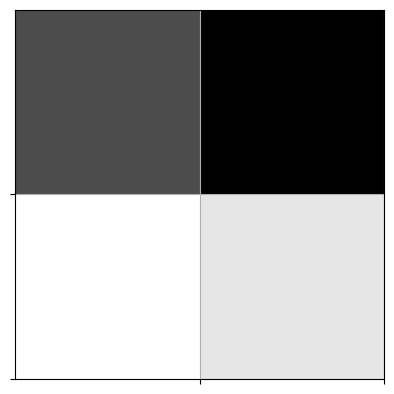

In [4]:
maze = generate_random_maze(2, 2, (0, 0), (1, 1))
qmaze = Qmaze(maze=maze)
show(qmaze)

In [5]:
class Model(object):
    def __init__(self, maze: list, learning_rate: float = 0.001):
        model = Sequential()
        
        model.add(Input(shape=(maze.size,)))
        model.add(Dense(maze.size))
        model.add(PReLU())

        model.add(Dense(maze.size))
        model.add(PReLU())

        model.add(Dense(num_actions))

        model.compile(optimizer="adam", loss="mse")
        self.model = model
        self.learning_rate = learning_rate

    def get_model(self):
        return self.model

## Create a Trial

Create an `Trial` class that accepts a trained neural network which calculates the next action, a Qmaze and the initial cell that the mouse is in.


In [6]:
class Trial:
    def __init__(self, model: Model, qmaze: Qmaze, mouse_cell: list):
        self._qmaze = qmaze
        self._model = model
        self.mouse_cell = mouse_cell

    def run(self):
        print("running trial...")
        mouse_cell = self._get_mouse_cell()
        self._qmaze.reset(mouse_cell)
        env_state = self._qmaze.observe()
        while True:
            prev_env_state = env_state
            Q = self._model.get_model().predict(prev_env_state, verbose=0)
            action = np.argmax(Q[0])
            _, _, status = self._qmaze.act(action)
            if status == "win":
                return True
            elif status == "lose":
                return False

    # For small mazes we can allow ourselves to perform a completion check in which we simulate all possible
    # games and check if our model wins the all. This is not practical for large mazes as it slows down training.
    def check(self):
        self._qmaze = self._get_maze()
        for cell in self._qmaze.free_cells:
            if not self._qmaze.valid_actions(cell):
                return False
            if not self.run():
                return False
        return True

    def _get_maze(self):
        return self._qmaze

    def _get_model(self):
        return self._model

    def _get_mouse_cell(self):
        return self.mouse_cell

## Creating a Class to Model the Experience of the Mouse

Create an `Experience` class that collects the experience of `Experiments` within a `list` of memory. It retreives a `model`, a `max_memory` which defines the maximum amount of experiments that the mouse can _remember_ and a `discount` factor which represents the instantanious uncertainty in the _Bellman equation for stochastic environments_.


In [7]:
class Experience(object):
    def __init__(self, model: Model, max_memory: int = 8, discount: float = 95 / 100):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.actions = model.get_model().output_shape[-1]

    def remember(self, trial):
        self.memory.append(trial)
        if len(self.memory) > self.max_memory:
            # delete the first element of the memory list if we exceed the max memory
            del self.memory[0]

    def predict(self, env_state):
        return self.model.get_model().predict(env_state, verbose=0)[0]

    def data(self, data_size: int = 10):
        environment_size = self.memory[0][0].shape[1]
        memory_size = len(self.memory)
        data_size = min(memory_size, data_size)
        inputs = np.zeros((data_size, environment_size))
        targets = np.zeros((data_size, self.actions))
        for idx, jdx in enumerate(
            np.random.choice(range(memory_size), data_size, replace=False)
        ):
            env_state, action, reward, env_state_next, trial_over = self.memory[jdx]
            inputs[idx] = env_state
            # There should be no target values for actions not taken.
            targets[idx] = self.predict(env_state)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(env_state_next))
            if trial_over:
                targets[idx, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[idx, action] = reward + self.discount * Q_sa
        return inputs, targets

# Q-Training Algorithm for Reinforcement Learning of Mouse
The algorithm accepts the a `number_epoch` which is the number of epochs, the maximum memory `max_memory` which is the maximum number of trials kept in memory and the `data_size` which is the number of  samples in training epoch. This is the number of trials randomly selected from the mouse's experience

In [8]:
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

Displaying Maze 1 (seed: 449650)


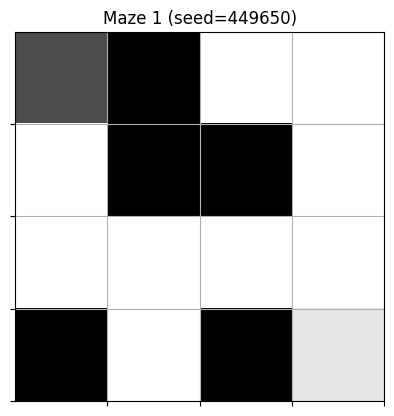

Displaying Maze 2 (seed: 14401)


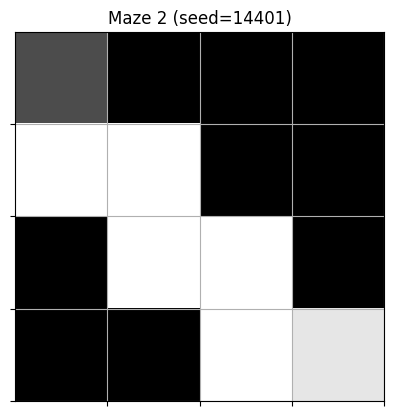

Displaying Maze 3 (seed: 798382)


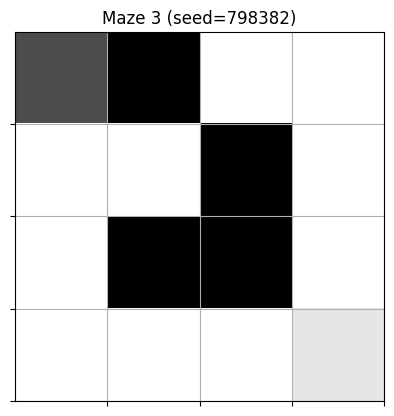

Displaying Maze 4 (seed: 118994)


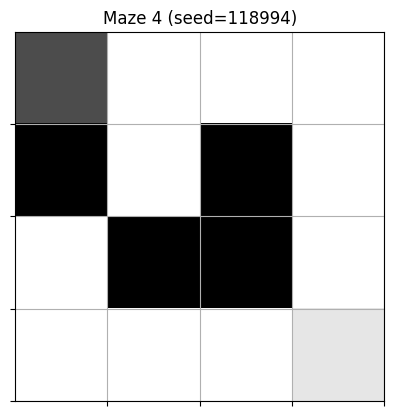

Displaying Maze 5 (seed: 528624)


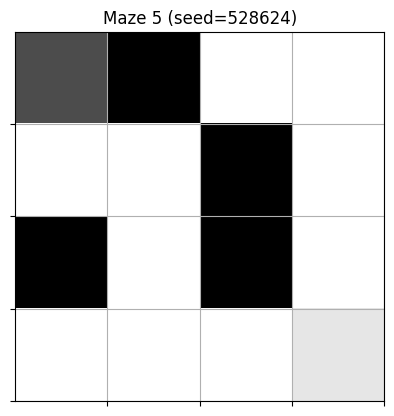

Saved 5 mazes and metadata to ../experiments/mazes


In [ ]:
def save_mazes(num=5, size=(4, 4), folder="../experiments/mazes"):
    os.makedirs(folder, exist_ok=True)
    metadata = {}

    for i in range(1, num+1):
        seed = random.randint(0, 1_000_000)
        random.seed(seed)
        np.random.seed(seed)
        
        rows, cols = size
        maze = generate_random_maze(rows, cols)
        maze[rows - 1, cols - 1] = 1.0
        maze[0, 0] = 1.0 

        print(f"Displaying Maze {i} (seed: {seed})")
        show(Qmaze(maze))
        plt.title(f"Maze {i} (seed={seed})")
        plt.show()

        filename = f"maze_{i}.npy"
        full_path = os.path.join(folder, filename)
        np.save(full_path, maze)

        metadata[f"maze_{i}"] = {
            "file": filename,
            "seed": seed,
            "size": size
        }

    with open(os.path.join(folder, "mazes.json"), "w") as f:
        json.dump(metadata, f, indent=4)

    print(f"Saved {num} mazes and metadata to {folder}")

# save_mazes()

In [10]:
class Experiment(object):
    def __init__(self, maze=generate_random_maze(), model_learning_rate: int = 0.001):
        qmaze = Qmaze(maze)
        show(Qmaze(maze))
        plt.title(f"Maze")
        plt.show()
        
        model = Model(maze, learning_rate=model_learning_rate)
        trial = Trial(model, qmaze, (0, 0))
        self.qmaze = qmaze
        self.model = model
        self.trial = trial

    def train(self, log_file=None, **opt):
        show(self.qmaze)
        print("training....")
        global epsilon
        number_epoch = opt.get("epochs", 100)
        max_memory = opt.get("max_memory", 8)
        data_size = opt.get("data_size", 25)
        name = opt.get("name", "model")
        start_time = datetime.datetime.now()

        data_folder = f"../experiments/{name}"
        os.makedirs(data_folder, exist_ok=True)

        if log_file is None:
            log_file = f"{data_folder}/{name}_training_metrics.csv"

        # Initialize experience replay object
        experience = Experience(self.model, max_memory=max_memory)
        completion_history = []  # history of win/lose game
        number_free_cells = len(self.qmaze.free_cells)
        hsize = self.qmaze.maze.size // 2  # history window size
        win_rate = 0.0
        imctr = 1

        with open(log_file, mode='w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=[
                "epoch", "loss", "steps", "win", "win_rate",
                "optimal_path_length", "suboptimal_steps", "total_reward", 
                "learning_rate", "elapsed_time"
            ])
            writer.writeheader()

            for epoch in range(number_epoch):
                loss = 0.0
                mouse_cell = random.choice(self.qmaze.free_cells)
                self.qmaze.reset(mouse_cell)
                trial_over = False
                env_state = self.qmaze.observe()
                n_trials = 0
                total_reward = 0

                row, col, _ = self.qmaze.state
                visited_positions = [(row, col)]

                while not trial_over:
                    valid_actions = self.qmaze.valid_actions()
                    if not valid_actions:
                        break
                    prev_env_state = env_state
                    # Get next action
                    if np.random.rand() < epsilon:
                        action = random.choice(valid_actions)
                    else:
                        action = np.argmax(experience.predict(prev_env_state))

                    # Apply action, get reward and new env_state
                    env_state, reward, status = self.qmaze.act(action)
                    visited_positions.append(self.qmaze.state[:2])
                    total_reward += reward

                    if status == "win":
                        completion_history.append(1)
                        trial_over = True
                    elif status == "lose":
                        completion_history.append(0)
                        trial_over = True
                    else:
                        trial_over = False

                    # Store trial (experience)
                    trial = [prev_env_state, action, reward, env_state, trial_over]
                    experience.remember(trial)
                    n_trials += 1

                    # Train neural network model
                    inputs, targets = experience.data(data_size=data_size)
                    self.model.model.fit(
                        inputs,
                        targets,
                        epochs=1,
                        batch_size=16,
                        verbose=0
                    )
                    loss = self.model.model.evaluate(inputs, targets, verbose=0)

                # Optimal path length via BFS
                try:
                    optimal_path = self.qmaze.shortest_path(mouse_cell)
                    optimal_length = len(optimal_path)
                except:
                    optimal_length = -1  # fallback if path not found

                suboptimal_steps = max(0, n_trials - optimal_length)

                if len(completion_history) > hsize:
                    win_rate = sum(completion_history[-hsize:]) / hsize

                dt = datetime.datetime.now() - start_time
                t = format_time(dt.total_seconds())

                print(
                    f"Epoch: {epoch+1}/{number_epoch} | Loss: {loss:.4f} | "
                    f"Trials: {n_trials} | Win count: {sum(completion_history)} | "
                    f"Win rate: {win_rate:.3f} | Time: {t}"
                )

                # Log metrics to CSV
                writer.writerow({
                    "epoch": epoch,
                    "loss": loss,
                    "steps": n_trials,
                    "win": int(status == "win"),
                    "win_rate": win_rate,
                    "optimal_path_length": optimal_length,
                    "suboptimal_steps": suboptimal_steps,
                    "total_reward": total_reward,
                    "learning_rate": self.model.learning_rate,
                    "elapsed_time": dt.total_seconds(),
                })

                if win_rate > 0.9:
                    epsilon = 0.05

                if sum(completion_history[-hsize:]) == hsize:
                    print("Reached 100%% win rate at epoch: %d" % (epoch,))
                    break

        # Save trained model weights and architecture to the created folder
        model_path = self.model.get_model()
        model_path.save_weights(f"{data_folder}/{name}.weights.h5", overwrite=True)
        with open(f"{data_folder}/{name}.json", "w") as outfile:
            json.dump(model_path.to_json(), outfile)
        model_path.save(f"{data_folder}/{name}_model.keras")

        # Report training summary
        elapsed = datetime.datetime.now() - start_time
        total_seconds = elapsed.total_seconds()
        print(f"files: {data_folder}/{name}.weights.h5, {data_folder}/{name}.json")
        print(f"n_epoch: {epoch}, max_mem: {max_memory}, data: {data_size}, time: {format_time(total_seconds)}")


## Train the Model

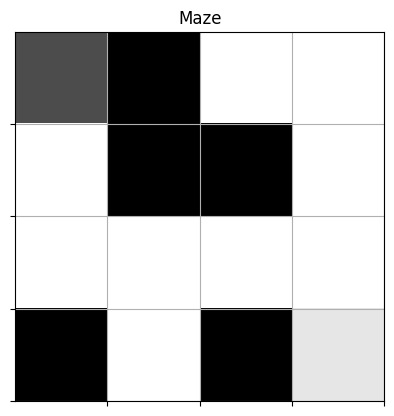

Running experiment: baseline_01
training....
Epoch: 1/100 | Loss: 0.0096 | Trials: 37 | Win count: 0 | Win rate: 0.000 | Time: 54.5 seconds
Epoch: 2/100 | Loss: 0.0552 | Trials: 11 | Win count: 1 | Win rate: 0.000 | Time: 68.3 seconds
Epoch: 3/100 | Loss: 0.0483 | Trials: 10 | Win count: 2 | Win rate: 0.000 | Time: 82.6 seconds
Epoch: 4/100 | Loss: 0.0105 | Trials: 35 | Win count: 2 | Win rate: 0.000 | Time: 133.3 seconds
Epoch: 5/100 | Loss: 0.0862 | Trials: 15 | Win count: 3 | Win rate: 0.000 | Time: 152.6 seconds
Epoch: 6/100 | Loss: 0.0159 | Trials: 35 | Win count: 3 | Win rate: 0.000 | Time: 197.0 seconds
Epoch: 7/100 | Loss: 0.1518 | Trials: 24 | Win count: 4 | Win rate: 0.000 | Time: 227.5 seconds
Epoch: 8/100 | Loss: 0.1244 | Trials: 16 | Win count: 5 | Win rate: 0.000 | Time: 247.8 seconds
Epoch: 9/100 | Loss: 0.1343 | Trials: 17 | Win count: 6 | Win rate: 0.750 | Time: 269.6 seconds
Epoch: 10/100 | Loss: 0.1455 | Trials: 26 | Win count: 7 | Win rate: 0.750 | Time: 303.3 secon

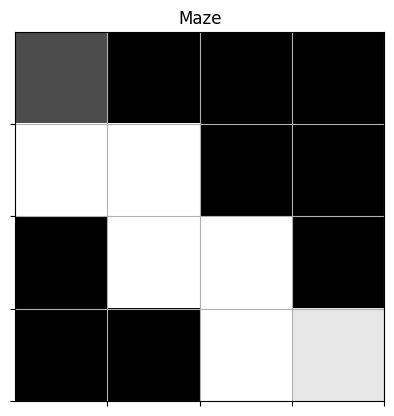

Running experiment: baseline_02
training....
Epoch: 1/100 | Loss: 0.0098 | Trials: 35 | Win count: 0 | Win rate: 0.000 | Time: 41.0 seconds
Epoch: 2/100 | Loss: 0.0773 | Trials: 33 | Win count: 1 | Win rate: 0.000 | Time: 83.0 seconds
Epoch: 3/100 | Loss: 0.0119 | Trials: 36 | Win count: 1 | Win rate: 0.000 | Time: 128.3 seconds
Epoch: 4/100 | Loss: 0.1620 | Trials: 27 | Win count: 2 | Win rate: 0.000 | Time: 162.0 seconds
Epoch: 5/100 | Loss: 0.0644 | Trials: 34 | Win count: 2 | Win rate: 0.000 | Time: 205.1 seconds
Epoch: 6/100 | Loss: 0.1592 | Trials: 33 | Win count: 2 | Win rate: 0.000 | Time: 246.0 seconds
Epoch: 7/100 | Loss: 0.2279 | Trials: 33 | Win count: 2 | Win rate: 0.000 | Time: 288.0 seconds
Epoch: 8/100 | Loss: 0.2555 | Trials: 34 | Win count: 2 | Win rate: 0.000 | Time: 330.6 seconds
Epoch: 9/100 | Loss: 0.1572 | Trials: 35 | Win count: 2 | Win rate: 0.250 | Time: 374.4 seconds
Epoch: 10/100 | Loss: 0.1735 | Trials: 33 | Win count: 2 | Win rate: 0.125 | Time: 6.96 minut

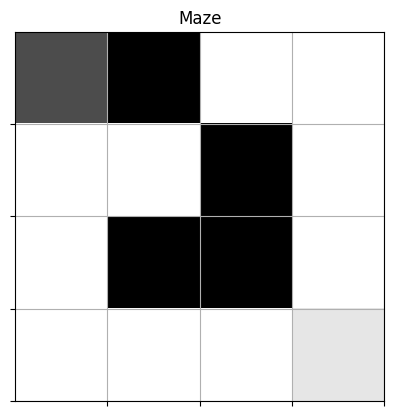

Running experiment: baseline_03
training....
Epoch: 1/100 | Loss: 0.0143 | Trials: 35 | Win count: 0 | Win rate: 0.000 | Time: 47.7 seconds
Epoch: 2/100 | Loss: 0.0178 | Trials: 35 | Win count: 0 | Win rate: 0.000 | Time: 104.9 seconds
Epoch: 3/100 | Loss: 0.1127 | Trials: 18 | Win count: 1 | Win rate: 0.000 | Time: 130.9 seconds
Epoch: 4/100 | Loss: 0.0068 | Trials: 35 | Win count: 1 | Win rate: 0.000 | Time: 184.4 seconds
Epoch: 5/100 | Loss: 0.0099 | Trials: 35 | Win count: 1 | Win rate: 0.000 | Time: 236.0 seconds
Epoch: 6/100 | Loss: 0.0852 | Trials: 17 | Win count: 2 | Win rate: 0.000 | Time: 257.7 seconds
Epoch: 7/100 | Loss: 0.0147 | Trials: 36 | Win count: 2 | Win rate: 0.000 | Time: 310.3 seconds
Epoch: 8/100 | Loss: 0.0453 | Trials: 35 | Win count: 2 | Win rate: 0.000 | Time: 368.1 seconds
Epoch: 9/100 | Loss: 0.1425 | Trials: 34 | Win count: 2 | Win rate: 0.250 | Time: 7.03 minutes
Epoch: 10/100 | Loss: 0.1035 | Trials: 36 | Win count: 2 | Win rate: 0.250 | Time: 8.08 minut

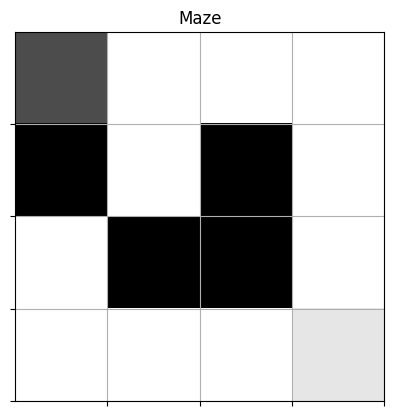

Running experiment: baseline_04
training....
Epoch: 1/100 | Loss: 0.0095 | Trials: 36 | Win count: 0 | Win rate: 0.000 | Time: 48.3 seconds
Epoch: 2/100 | Loss: 0.0142 | Trials: 34 | Win count: 0 | Win rate: 0.000 | Time: 97.1 seconds
Epoch: 3/100 | Loss: 0.0563 | Trials: 35 | Win count: 0 | Win rate: 0.000 | Time: 146.3 seconds
Epoch: 4/100 | Loss: 0.2572 | Trials: 2 | Win count: 1 | Win rate: 0.000 | Time: 149.1 seconds
Epoch: 5/100 | Loss: 0.1946 | Trials: 26 | Win count: 2 | Win rate: 0.000 | Time: 188.5 seconds
Epoch: 6/100 | Loss: 0.2154 | Trials: 24 | Win count: 3 | Win rate: 0.000 | Time: 234.2 seconds
Epoch: 7/100 | Loss: 0.4047 | Trials: 3 | Win count: 4 | Win rate: 0.000 | Time: 239.6 seconds
Epoch: 8/100 | Loss: 0.5389 | Trials: 3 | Win count: 5 | Win rate: 0.000 | Time: 244.5 seconds
Epoch: 9/100 | Loss: 0.0315 | Trials: 33 | Win count: 5 | Win rate: 0.625 | Time: 299.7 seconds
Epoch: 10/100 | Loss: 0.1681 | Trials: 13 | Win count: 6 | Win rate: 0.750 | Time: 328.7 seconds

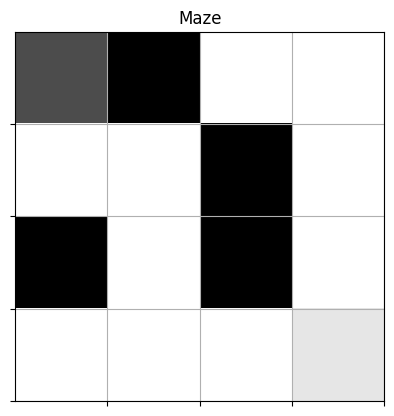

Running experiment: baseline_05
training....
Epoch: 1/100 | Loss: 0.0156 | Trials: 35 | Win count: 0 | Win rate: 0.000 | Time: 84.4 seconds
Epoch: 2/100 | Loss: 0.0143 | Trials: 33 | Win count: 0 | Win rate: 0.000 | Time: 153.9 seconds
Epoch: 3/100 | Loss: 0.0120 | Trials: 34 | Win count: 0 | Win rate: 0.000 | Time: 210.9 seconds
Epoch: 4/100 | Loss: 0.0501 | Trials: 3 | Win count: 1 | Win rate: 0.000 | Time: 214.8 seconds
Epoch: 5/100 | Loss: 0.0906 | Trials: 1 | Win count: 2 | Win rate: 0.000 | Time: 216.0 seconds
Epoch: 6/100 | Loss: 0.0545 | Trials: 18 | Win count: 3 | Win rate: 0.000 | Time: 239.0 seconds
Epoch: 7/100 | Loss: 0.0876 | Trials: 2 | Win count: 4 | Win rate: 0.000 | Time: 242.7 seconds
Epoch: 8/100 | Loss: 0.0110 | Trials: 36 | Win count: 4 | Win rate: 0.000 | Time: 303.7 seconds
Epoch: 9/100 | Loss: 0.0685 | Trials: 28 | Win count: 5 | Win rate: 0.625 | Time: 355.5 seconds
Epoch: 10/100 | Loss: 0.1291 | Trials: 3 | Win count: 6 | Win rate: 0.750 | Time: 363.9 seconds

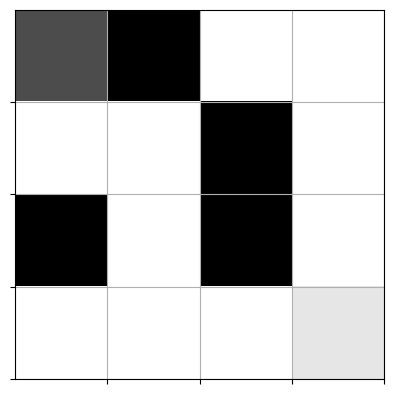

In [11]:
for i in range(1, 6):
    name = f"baseline_{i:02d}"
    
    # load the pre-generated maze
    maze_path = f"../experiments/mazes/maze_{i}.npy"  # adjust path if needed
    maze = np.load(maze_path)

    # create a new instance of Experiment with the loaded maze
    experiment = Experiment(maze=maze)

    print(f"Running experiment: {name}")
    experiment.train(name=name)